# Imports

In [24]:
# Standard library imports
import copy
import math
import timeit
from warnings import warn

# Numeric operations
import numpy as np
import pandas as pd

# Image processing and computer vision
import cv2
from PIL import Image, ImageFilter
import skimage
from skimage.feature import blob_log
from skimage import data, exposure, filters, io, measure, morphology, feature, color, util
from skimage.filters import (threshold_mean, threshold_isodata, threshold_minimum,
                             threshold_otsu, threshold_triangle, threshold_li)
if int(skimage.__version__.split('.')[1]) < 14:
    warn('Your skimage version is: {} but the recommended version is 0.14.0.' 
         'Some features may not work if you do not have the latest version.'.format(skimage.__version__))

# Visualization / Plotting
from matplotlib import pyplot as plt, image as mpimg, patches
from matplotlib.patches import Circle
# Ensuring that matplotlib plots inline for Jupyter notebooks
%matplotlib inline

# Scientific computing and statistics
from scipy.optimize import curve_fit
from scipy.stats import norm

import tkinter as tk #for opening files with a GUI
from tkinter import filedialog
import os  # Import the os module

# Load Image and Convert to Greyscale

Image shape (#rows, # columns, # color channels): (835, 835, 3)
Before conversion to float: data type: uint8, min: 134, max: 226
After conversion to float: data type: float64, min: 0.5254901960784314, max: 0.8862745098039215


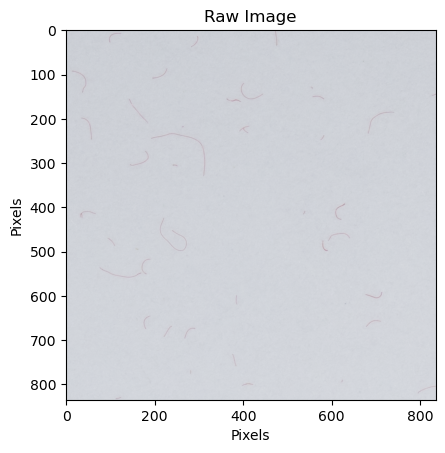

In [25]:
# Define file path and image name

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
root = tk.Tk()
root.withdraw()  # Hide the main window.
file_path = filedialog.askopenfilename() # to open the file
img_name = os.path.basename(file_path)  # Extract the file name from the full path
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# reading the image
raw_image = skimage.io.imread(file_path)

# Display image properties
print("Image shape (#rows, # columns, # color channels):", raw_image.shape)
print(f'Before conversion to float: data type: {raw_image.dtype}, min: {raw_image.min()}, max: {raw_image.max()}')

# Convert to float and display the raw image
float_image = skimage.util.img_as_float(raw_image)
print(f'After conversion to float: data type: {float_image.dtype}, min: {float_image.min()}, max: {float_image.max()}')

plt.figure(dpi=100)
plt.imshow(float_image, cmap='gray')
plt.title('Raw Image')
plt.xlabel('Pixels') 
plt.ylabel('Pixels')
plt.show()

# Convert to grayscale, invert colors
gray_image = skimage.color.rgb2gray(float_image)


# Remove Image Background

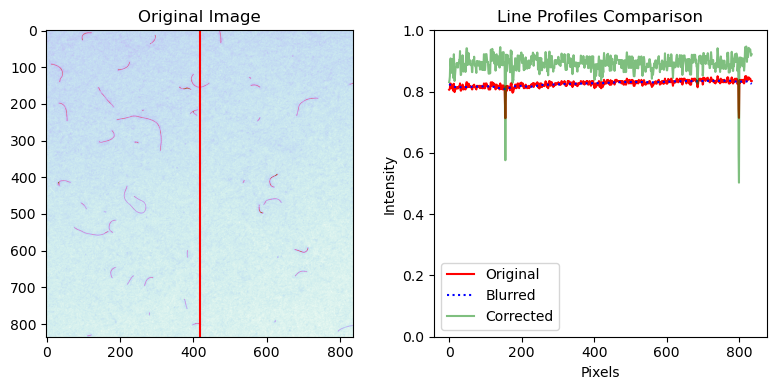

In [26]:
y_pixels, x_pixels = gray_image.shape

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#edit this to change the line profile displayed
section_x=x_pixels//2
#edit this to adjust units based off of the pixel size in your image
calibration_factor=0.01675 # mm/pixel
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Define the spatial dimensions and the reciprocal space parameters
x_edge_length, y_edge_length = x_pixels*calibration_factor, y_pixels*calibration_factor  # dimensions of the image in millimeters
x_sampling = x_pixels / x_edge_length # finds the # of px/mm along x and y dimensions
y_sampling = y_pixels / y_edge_length
x_axis_vec = np.linspace(-x_edge_length / 2, x_edge_length / 2, x_pixels) # Generate linearly spaced vectors representing the physical positions across the image's dimensions
y_axis_vec = np.linspace(-y_edge_length / 2, y_edge_length / 2, y_pixels)
x_mat, y_mat = np.meshgrid(x_axis_vec, y_axis_vec) #Creates matrices of x and y positions for each pixel in the image

# Prepare for Fourier Transform:
u_max = x_sampling / 2 #Determine the maximum frequencies (in reciprocal millimeters) that can be resolved in the Fourier domain given the sampling rates according to the Nyquist-Shannon theorem
v_max = y_sampling / 2
u_axis_vec = np.linspace(-u_max, u_max, x_pixels) #Create vectors of frequency values along each axis in the reciprocal space
v_axis_vec = np.linspace(-v_max, v_max, y_pixels)
u_mat, v_mat = np.meshgrid(u_axis_vec, v_axis_vec) #Generate matrices of frequency positions for the Fourier domain
r = np.sqrt(u_mat**2 + v_mat**2) #Calculate the radial distance from the center of the Fourier domain for each point (used to define the Gaussian filter)

# Gaussian filter in reciprocal space
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# edit to change the size of the filter
filter_width = 1 # Sets the width of the Gaussian filter in reciprocal space
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
inverse_gauss_filter = 1 - np.exp(-(r * filter_width)**2) #Defines the high pass Gaussian filter in the frequency domain, which attenuates low frequency information
gauss_filter= np.exp(-(r * filter_width)**2)# Gaussian filter, to visualize blurring

# FFT of the image, application of the filter, and IFFT to get the corrected image
fft_image_w_background = np.fft.fftshift(np.fft.fft2(gray_image)) #Computes the 2D Fourier transform of the image and shifts the zero-frequency component to the center
fft_image_corrected = fft_image_w_background * inverse_gauss_filter #Applies the high pass Gaussian filter to the Fourier-transformed image, removing low freq info
image_corrected = np.real(np.fft.ifft2(np.fft.ifftshift(fft_image_corrected))) #Inverse Fourier transform to convert the filtered image back to the spatial domain

# FFT of the image, application of the filter, and IFFT to get the corrected image
fft_image_blurred = fft_image_w_background * gauss_filter #Applies the Gaussian filter to the Fourier-transformed image, blurring it 
image_blurred = np.real(np.fft.ifft2(np.fft.ifftshift(fft_image_blurred))) #Inverse Fourier transform to convert the blurred image back to the spatial domain

# Normalization, [0,1]
corrected_normalized = (image_corrected - image_corrected.min()) / (image_corrected.max() - image_corrected.min())
blurred_normalized = (image_blurred - image_blurred.min()) / (image_blurred.max() - image_blurred.min())

# Calculating line profiles for the blurred and corrected images
line_profile_original = np.squeeze(gray_image[:, section_x])
line_profile_blurred = np.squeeze(image_blurred[:, section_x])
line_profile_corrected = np.squeeze(corrected_normalized[:, section_x])

# Visualization 
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

# Displaying the original and filtered images side by side
axes[0].imshow(gray_image, cmap='cubehelix')
axes[0].set_title('Original Image')
axes[0].axvline(x=section_x, color='r') # Marking the section line

# Plotting the line profiles for the original, blurred, and corrected images 
axes[1].plot(line_profile_original, color='r', label='Original')
axes[1].plot(line_profile_blurred, color='b', label='Blurred', linestyle='dotted')
axes[1].plot(line_profile_corrected, color='g', label='Corrected', alpha=0.5)
axes[1].set_title('Line Profiles Comparison')
axes[1].set_xlabel('Pixels')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].set_ylim([0, 1])

fig.tight_layout()
plt.show()

# Circular Crop and Renormalization 

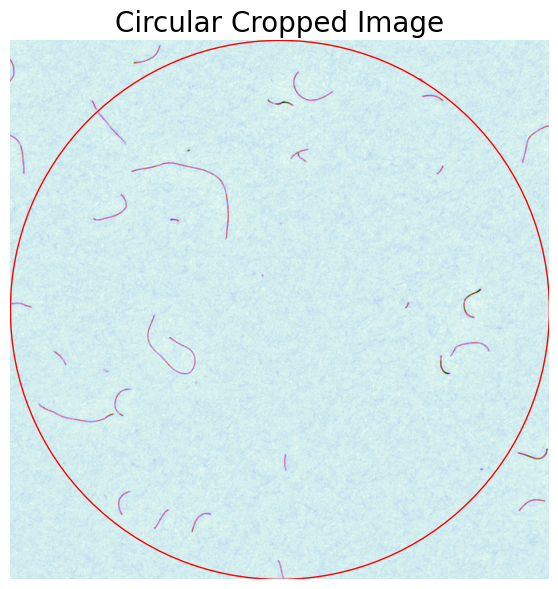

In [27]:
# Crop the image with a border to center the filter paper, use below figure to ensure ideal cropping.
# Can skip this step if entire circular filter paper is not imaged
height, width = corrected_normalized.shape

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# edit to adjust the circular crop
border = 80 # a border of this many pixels is removed from the image
right_shift = 40 # the image can then be shifted (right, left, up, down)to center it
down_shift = 0 #the image shift cannot exceed to border
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

border_cropped_image = corrected_normalized[border-down_shift:height-border-down_shift, border-right_shift:width-border-right_shift]

# Create a circular mask
cropped_height, cropped_width = border_cropped_image.shape
y, x = np.ogrid[:cropped_height, :cropped_width]
center_y, center_x = cropped_height / 2, cropped_width / 2
radius = cropped_height / 2
distance_from_center = (y - center_y)**2 + (x - center_x)**2
circular_mask = distance_from_center > radius**2

# Apply the circular mask to select pixels within the circle
pixels_inside_circle = border_cropped_image[circular_mask]

# Calculate the median pixel value of the pixels inside the circle
median_pixel_value = np.median(pixels_inside_circle)

# Apply the circular mask to the cropped image
circular_cropped_image = border_cropped_image.copy()
circular_cropped_image[circular_mask] = median_pixel_value  # Set pixels outside the circle to 0 (black)

# Display the circular cropped image
fig, axis = plt.subplots(figsize=(7, 7))
axis.imshow(border_cropped_image, cmap='cubehelix')
axis.set_title('Circular Cropped Image', fontsize=20)
axis.axis('off')  # Optionally, turn off the axis
# Draw the circle with a red outline
circle = Circle((center_x, center_y), radius, color='red', fill=False, linewidth=1)
axis.add_patch(circle)
plt.show()


# Invert Image

In [28]:
inverted_circular_cropped_image = 1 - circular_cropped_image  # Inverting the grayscale values 

# Convert Image to Binary

Threshold value: 0.30049147653868113


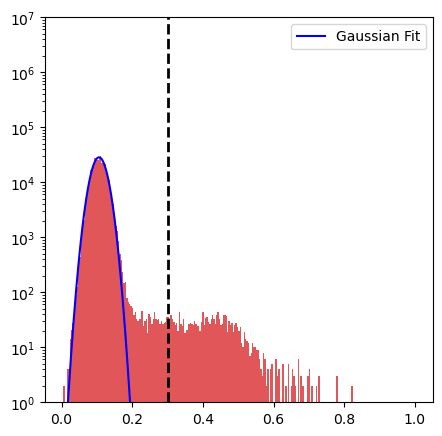

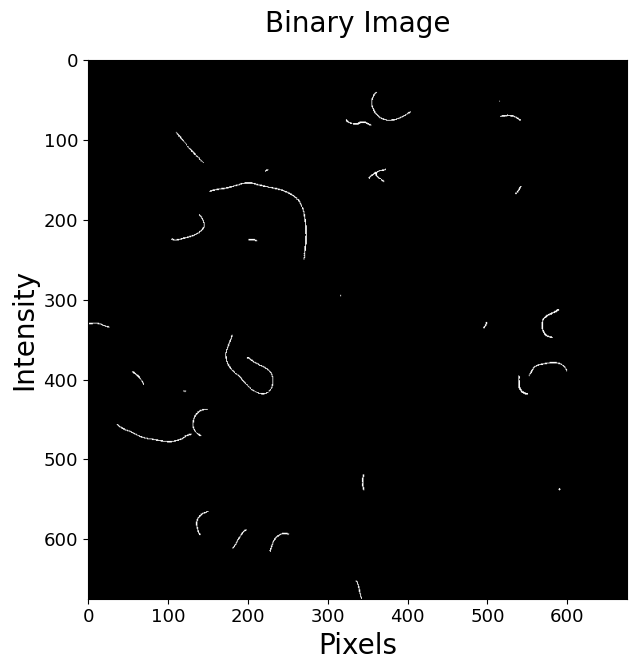

In [29]:
# Function for Gaussian
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation**2))

# Use only the pixels inside the circular mask for histogram and Gaussian fit
data_inside_circle = inverted_circular_cropped_image[~circular_mask]

# Histogram and Gaussian Fit with Logarithmic Scale
fig1, axis = plt.subplots(figsize=(5, 5));
n, bins, patches = plt.hist(data_inside_circle.ravel(), 255, color='#e15759', edgecolor='none');
plt.yscale('log');
plt.ylim(1, 10**7);  # Setting y-axis limits

# Calculate a generic initial guess for standard deviation
std_dev_guess = (max(data_inside_circle) - min(data_inside_circle)) / len(bins)

# Identifying the first large peak
bin_centers = 0.5 * (bins[1:] + bins[:-1])
max_bin = np.argmax(n)  # index of first large peak
popt, _ = curve_fit(gaussian, bin_centers, n, p0=[bin_centers[max_bin], n[max_bin], std_dev_guess])

# Plotting the Gaussian fit on Logarithmic Scale Histogram
x_interval_for_fit = np.linspace(bin_centers[0], bin_centers[-1], 10000);
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian Fit', color='blue');
plt.legend();

# Calculating new threshold based on Gaussian standard deviation
gaussian_std_dev = popt[2]

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# edit the multiplier to adjust the threshold offset
thresh = np.median(data_inside_circle) + 10 * gaussian_std_dev
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

print("Threshold value:", thresh)
plt.axvline(x=thresh, color='black', linewidth=2, linestyle='--') #add the threshold to the plot

# Plotting the thresholded image
fig2, axis = plt.subplots(figsize=(7, 7))
binary = inverted_circular_cropped_image.copy()
binary[inverted_circular_cropped_image < thresh] = 0
binary[inverted_circular_cropped_image >= thresh] = 255
im_handle = axis.imshow(binary, cmap='gray')
axis.set_title('Binary Image', pad=20,fontsize=20)
axis.set_xlabel('Pixels', fontsize=20)
axis.set_ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

#  Save the thresholded binary image as a PNG file
# plt.imsave('thresholded_image.png', binary, cmap='gray')

# Count Contours and Determine their Area

Number of large contours found: 26


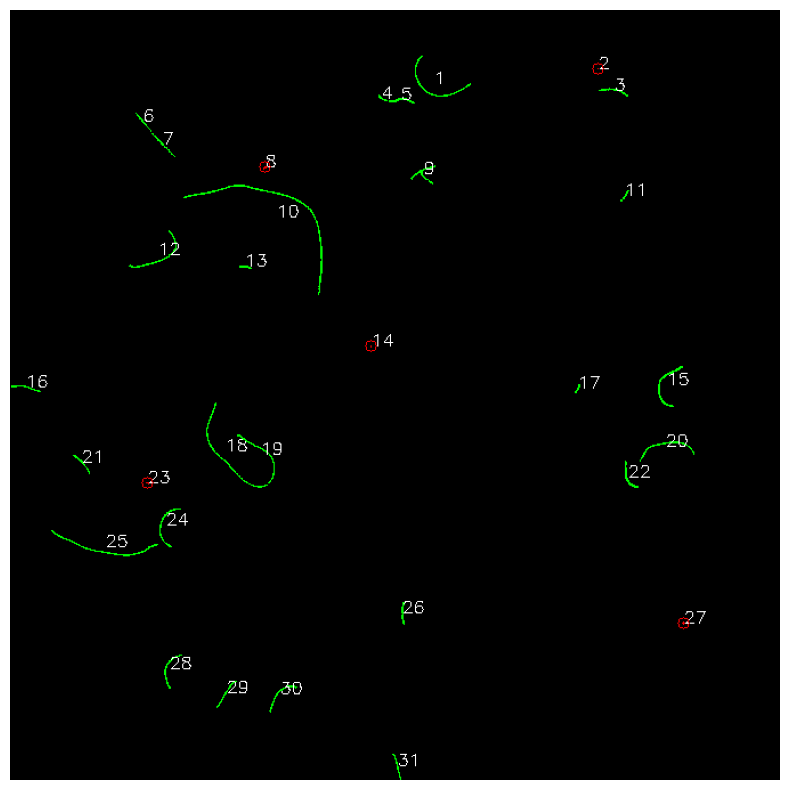

In [30]:
# Assuming 'binary' is your binary image as a NumPy array
binary_for_stats = np.uint8(binary)

# Apply connectedComponentsWithStats
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_for_stats, connectivity=8)

# Define the threshold for large contours
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# edit as necessry
large_contour_threshold = 10
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Create an empty color image (BGR)
contour_image = np.zeros((binary_for_stats.shape[0], binary_for_stats.shape[1], 3), dtype=np.uint8)

# Lists to store contour data
contour_areas = []
large_contours_count = 0

# Color the contours and draw circles for small contours
for i in range(1, num_labels):  # Start from 1 to ignore the background label
    area = stats[i, cv2.CC_STAT_AREA]
    contour_areas.append(area)  # Append the area directly as a number

    # Increment large contours count
    if area > large_contour_threshold:
        large_contours_count += 1

    # Choose color: green for large contours, red for small contours
    color = (0, 255, 0) if area > large_contour_threshold else (0, 0, 255)

    # Color the pixels belonging to each contour
    contour_image[labels == i] = color
    
    # Label each contour
    cx, cy = int(centroids[i][0]), int(centroids[i][1])
    cv2.putText(contour_image, str(i), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Draw a red circle around small contours
    if area <= large_contour_threshold:
        center = (int(centroids[i][0]), int(centroids[i][1]))
        cv2.circle(contour_image, center, 5, (0, 0, 255), 1)

# Print the number of large contours   
print("Number of large contours found:", large_contours_count)

# code for saving image data
# ================================================================
# # Define the folder path where the file will be saved
# folder_path = '/your/file/path/'

# # Extract the base name without extension and add '.xlsx' extension for the Excel file
# excel_file_name = img_name.split('.')[0] + '.xlsx'
# excel_file_path = folder_path + excel_file_name

# # Data for DataFrame
# data = {
#     "Total Number of Contours": [num_labels - 1] * len(contour_areas),
#     "Number of Large Contours": [large_contours_count] * len(contour_areas),
#     "Area of Contour": contour_areas
# }

# # Create DataFrame and save to Excel
# df = pd.DataFrame(data)
# df.to_excel(excel_file_path, index=False)
# ================================================================

# Plotting the image  
plt.figure(figsize=(10, 10)) 
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off the axis

# code for saving the image
# ================================================================
# # Define the filename for the plot
# plot_file_name = img_name.split('.')[0] + '_contours.png'
# plot_file_path = folder_path + plot_file_name

# # Save the plot with high DPI
# high_dpi = 600  # You can adjust this value as needed
# plt.savefig(plot_file_path, bbox_inches='tight', pad_inches=0, dpi=high_dpi)
# ================================================================

# Now display the plot
plt.show()


Number of blobs found: 28


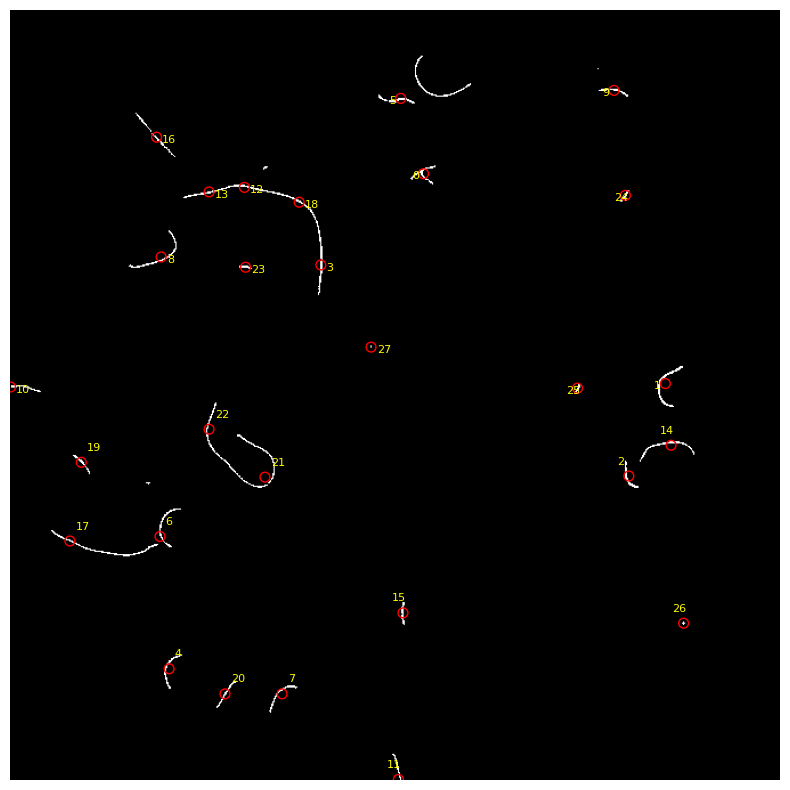

In [31]:
# Blob detection is not optimal for fibrous microplastics but is included here for comparison
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# edit parameters as necessry
blobs = blob_log(binary, min_sigma=16, max_sigma=25, num_sigma=1, threshold=0.005)
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Print the number of blobs found
num_blobs = len(blobs)  # Number of blobs
print("Number of blobs found:", num_blobs)

# Plotting blobs
plt.figure(figsize=(10, 10))
plt.imshow(binary, cmap='gray')

# Extract coordinates and radius of blobs and draw and label each blob
for i, (xi, yi) in enumerate(zip(blobs[:, 1], blobs[:, 0])):
    plt.scatter(xi, yi, marker='o', s=50, edgecolor='red', facecolor='none')

    # Determine the offsets based on the blob's position
    text_offset_x = 5 if xi < binary.shape[1] / 2 else -10
    text_offset_y = 5 if yi < binary.shape[0] / 2 else -10

    # Apply the offsets and ensure text stays within the image boundaries
    text_x = max(0, min(xi + text_offset_x, binary.shape[1] - 1))
    text_y = max(0, min(yi + text_offset_y, binary.shape[0] - 1))

    plt.text(text_x, text_y, str(i), color='yellow', fontsize=8)

plt.axis('off')  # Turn off the axis

# code for saving the image
# ================================================================
# # Define the filename for the plot
# plot_file_name = img_name.split('.')[0] + '_blobs.png'
# plot_file_path = folder_path + plot_file_name

# # Save the plot with high DPI
# high_dpi = 600  # You can adjust this value as needed
# plt.savefig(plot_file_path, bbox_inches='tight', pad_inches=0, dpi=high_dpi)
# ================================================================

# # Now display the plot
plt.show()